In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import os
import seaborn as sns

%matplotlib inline

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
train = pd.read_csv('data/train_balanced_5k.csv')
train.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=1)

part_codes = {'Ghost':0, 'Electron':11, 'Muon':13, 'Pion':211, 'Kaon':321, 'Proton':2212}
particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]

train_types = np.abs(train['MCParticleType'])
train_types_encoding = {part_codes[code]:index for index, code in enumerate(particles)}
labels = train_types.apply(lambda x: train_types_encoding[x])

mc_features = ['Unnamed: 0', 'HasMC', 'MCParticleType', 'MCParticleP', 'MCParticlePt', 'MCVirtualMass', 
               'MCFromB', 'MCFromD', 'MCVertexType', 'MCVertexX', 'MCVertexY', 'MCVertexZ', 
               'piplus_OWNPV_X', 'piplus_OWNPV_Y', 'piplus_OWNPV_Z', 'piplus_OWNPV_XERR', 
               'piplus_OWNPV_YERR', 'piplus_OWNPV_ZERR', 'piplus_OWNPV_CHI2', 'piplus_OWNPV_NDOF', 
               'piplus_IP_OWNPV', 'piplus_IPCHI2_OWNPV', 'nCandidate', 'totCandidates', 'EventInSequence', 
               'TrackHistory', 'TrackType', 'RecoPIDcode']

constant_features = ['TrackMatchChi2', 'TrackCloneDist', 'RichUsedAero']

features = list(set(train.columns) - set(mc_features + constant_features))
print features

['RichDLLpi', 'RichDLLe', 'CaloBremChi2', 'RichDLLp', 'HcalPIDe', 'RichAbovePiThres', 'InAccHcal', 'CaloElectronMatch', 'InAccEcal', 'TrackFitTChi2', 'NumUpstreamTracks', 'CaloBremMatch', 'NumProtoParticles', 'MuonIsLooseMuon', 'InAccSpd', 'CaloEcalChi2', 'MuonMuLL', 'TrackFitVeloNDoF', 'TrackLikelihood', 'CaloSpdE', 'RichAboveKaThres', 'EcalPIDe', 'CaloNeutralSpd', 'CombDLLmu', 'CombDLLpi', 'TrackGhostProbability', 'CaloTrMatch', 'MuonNShared', 'RichAboveMuThres', 'CaloNeutralEcal', 'RichAboveElThres', 'EcalPIDmu', 'NumMuonTracks', 'TrackFitVeloChi2', 'NumSPDHits', 'InAccPrs', 'CombDLLe', 'CombDLLk', 'CaloChargedSpd', 'NumDownstreamTracks', 'CaloEcalE', 'CaloClusChi2', 'CaloNeutralPrs', 'RichDLLbt', 'BremPIDe', 'CombDLLp', 'RichUsedR2Gas', 'InAccBrem', 'HcalPIDmu', 'TrackNumDof', 'PrsPIDe', 'RichDLLk', 'NumCaloHypos', 'VeloCharge', 'NumLongTracks', 'RichUsedR1Gas', 'NumRich1Hits', 'TrackP', 'CaloChargedPrs', 'MuonBkgLL', 'RichAbovePrThres', 'TrackFitMatchChi2', 'TrackFitTNDoF', 'CaloT

In [3]:
from sklearn.preprocessing import Imputer

to_log = ['CaloNeutralPrs', 'CaloPrsE', 'CaloHcalE', 'CaloNeutralEcal', 'CaloTrMatch', 'CaloElectronMatch', 'CaloChargedPrs',
          'MuonNShared', 'CaloBremMatch', 'TrackPt', 'TrackP', 'NumDownstreamTracks', 'CaloEcalChi2', 'NumRich1Hits',
          'NumMuonTracks', 'NumTTracks', 'TrackFitMatchChi2', 'TrackDOCA', 'CaloClusChi2', 'TrackFitVeloChi2',
          'CaloBremChi2', 'CaloChargedEcal', 'NumSPDHits', 'NumVeloTracks', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'NumRich2Hits', ]

to_log_negative = ['CaloTrajectoryL', 'MuonMuLL', 'RichDLLbt', 'CombDLLp', 'RichDLLe', 'TrackLikelihood', 'CombDLLk', 
                   'RichDLLp', 'CaloEcalE', 'RichDLLmu', 'RichDLLk', 'CombDLLe']

# CaloChargedSpd - 1 or -999
# CombDLLpi, RichDLLpi  0 or -999

def log1p_negative(array):
    negative = array < 0
    array = np.log1p(np.abs(array))
    array[negative] *= -1
    return array

unchanged_features = list(set(features) - set(to_log + to_log_negative))

### Признаки, оставленные без изменения

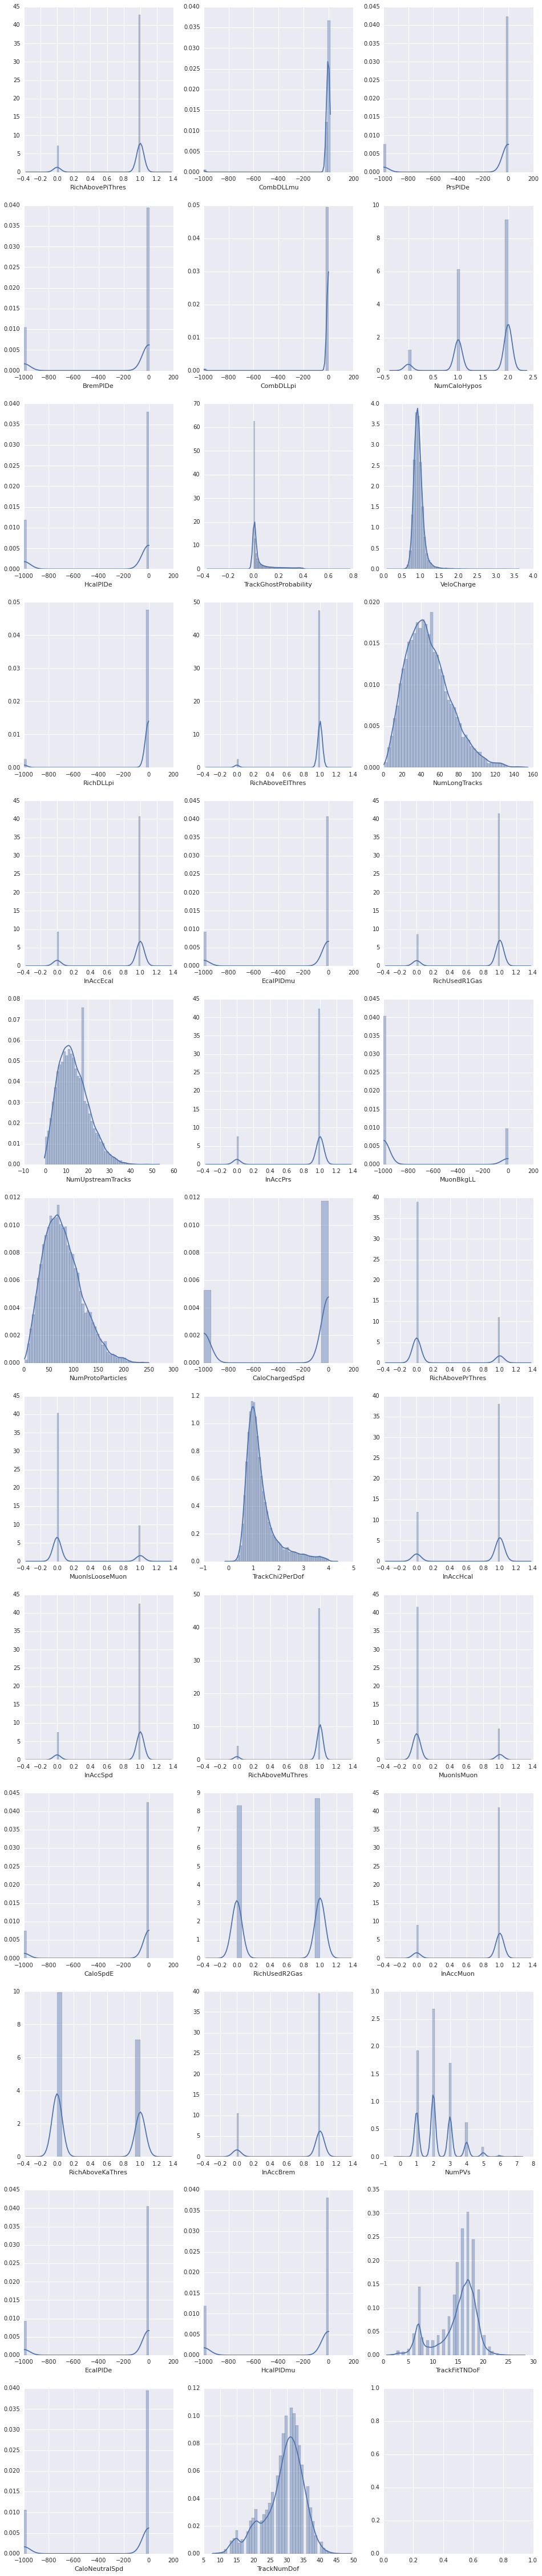

In [4]:
f, axes = plt.subplots(13, 3, figsize=(16, 80))
for index, name in enumerate(unchanged_features):
    row = index % 13
    col = index // 13
    sns.distplot(train[name], ax=axes[row, col])

### Признаки с log(1+x) преобразованием

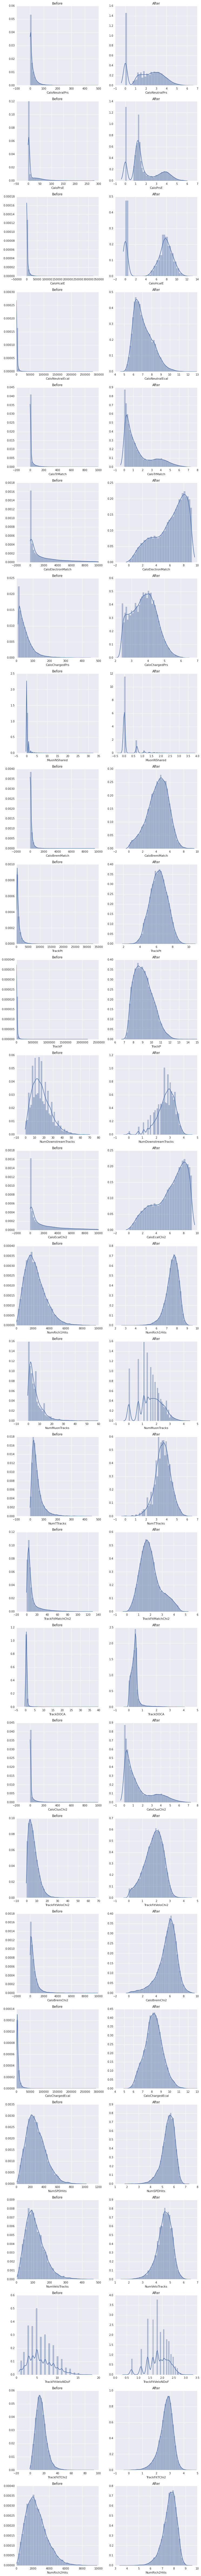

In [5]:
f, axes = plt.subplots(27, 2, figsize=(12, 170))

for index, col_name in enumerate(to_log):
    non_NaN = train[col_name] != -999
    sns.distplot(train.loc[non_NaN, col_name], ax=axes[index, 0])
    sns.distplot(np.log1p(train.loc[non_NaN, col_name]), ax=axes[index, 1])
    axes[index, 0].set_title('Before')
    axes[index, 1].set_title('After')

### Признаки с двусторонним log(1+x) преобразованием

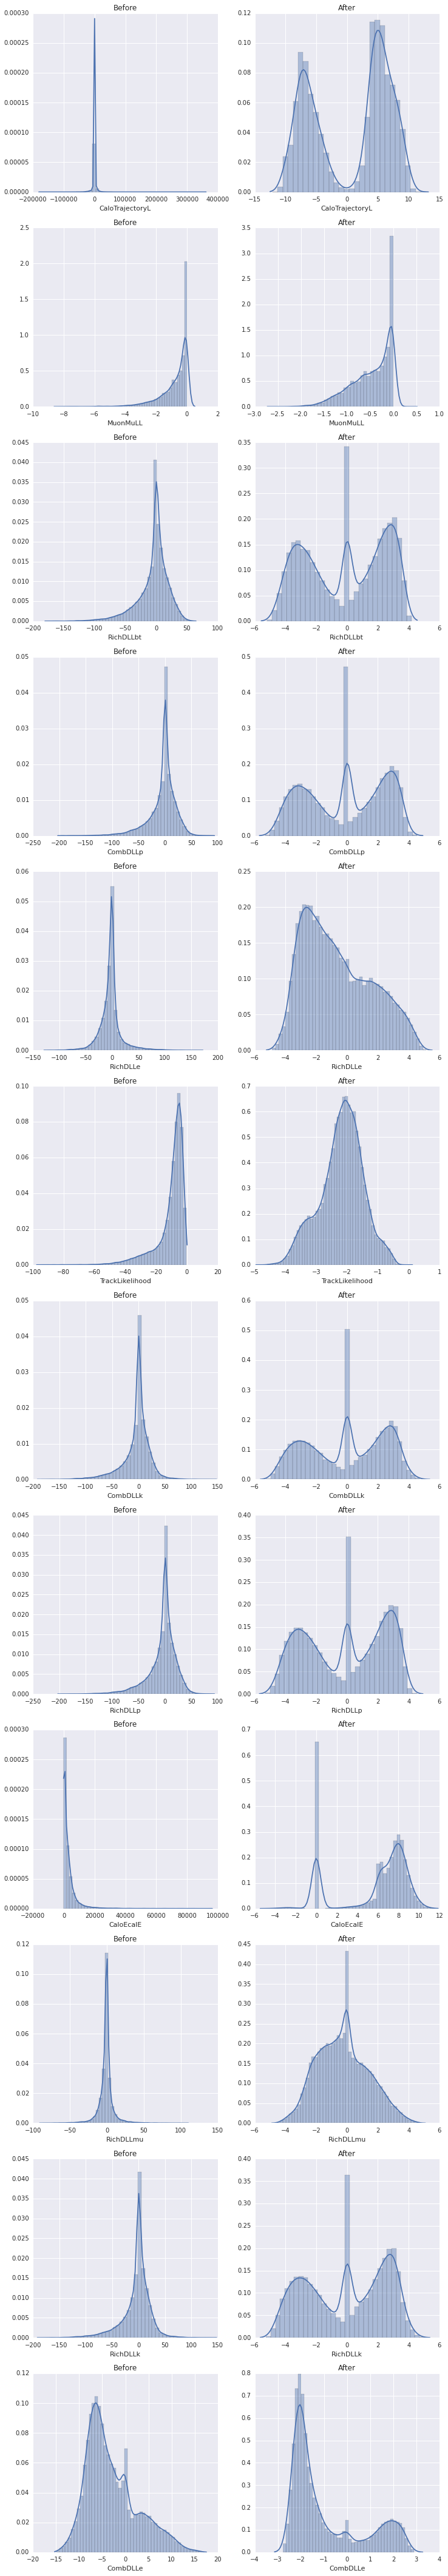

In [6]:
f, axes = plt.subplots(12, 2, figsize=(12, 75))

for index, col_name in enumerate(to_log_negative):
    non_NaN = train[col_name] != -999
    sns.distplot(train.loc[non_NaN, col_name], ax=axes[index, 0])
    sns.distplot(log1p_negative(train.loc[non_NaN, col_name]), ax=axes[index, 1])
    axes[index, 0].set_title('Before')
    axes[index, 1].set_title('After')